In [1]:
!pip install pytorch-tabnet
!pip install xgboost
#!gdown --id 1FCaUqClUl6zKb9fszETEIJsLXscTsz12
#!gdown --id "1BtJR_oIb1RHCS5rcLYrf--gZZXC2YuG8&confirm=t"
#!unzip results_mushroom.zip

DEPRECATION: pytorch-lightning 1.5.9 has a non-standard dependency specifier torch>=1.7.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.5.9 has a non-standard dependency specifier torch>=1.7.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


class MushroomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.data[idx]), torch.LongTensor([self.labels[idx]])


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
class ModifiedResNet(nn.Module):
    def __init__(self):
        super(ModifiedResNet, self).__init__()
        # Load a pre-trained ResNet model
        resnet = models.resnet18(pretrained=True)
        # Remove the last layer (fully connected layer)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])
        # Modify the first layer to accept grayscale images
        self.resnet_features[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Add Batch Normalization
        self.batch_norm = nn.BatchNorm1d(512)
        # Add dropout to reduce overfitting
        self.dropout = nn.Dropout(p=0.2)
        # Define additional layers for classification
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, 2)  # Output has 2 classes

    def forward(self, x):
        x = self.resnet_features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.batch_norm(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
# # Load data and labels
# tags = pd.read_csv('mushroom.csv')["class"]
# tags = np.array([i == "p" for i in tags]).astype(np.int64)  # binary

# with open("results.pkl", "rb") as f:
#     matrices_result, new_order_names = pickle.load(f)

# matrices_result = matrices_result[:, np.newaxis, :, :]  # 61069, 1, 39, 119

# # Split data into training, validation, and test sets randomly
# #data_to_use, loset_data, labels_to_use, losed_labels = train_test_split(matrices_result, tags, test_size=0.99, random_state=42)
# data_to_use, _,labels_to_use, _ = matrices_result, None, tags, None

# train_data, test_val_data, train_labels, test_val_labels = train_test_split(data_to_use, labels_to_use, test_size=0.3, random_state=42)
# val_data, test_data, val_labels, test_labels = train_test_split(test_val_data, test_val_labels, test_size=0.5, random_state=42)

def run_HERMANN(train_data, train_labels, val_data, val_labels,test_data, test_labels):
    # Create datasets and dataloaders
    train_dataset = MushroomDataset(train_data, train_labels)
    val_dataset = MushroomDataset(val_data, val_labels)
    test_dataset = MushroomDataset(test_data, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = ModifiedResNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Early stopping parameters
    patience = 5
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_weights = None

    # Training loop
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm.tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device).squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm.tqdm(val_loader):
                outputs = model(inputs.to(device))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels.to(device).squeeze()).sum().item()
                val_loss += criterion(outputs, labels.to(device).squeeze()).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss}, Accuracy on validation set: {100 * correct / total:.2f}%, Validation Loss: {val_loss:.4f}")

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model weights
            best_model_weights = model.state_dict()
            if best_val_loss == 0.:
              print(f'Early stopping after {epoch + 1} epochs.')
              break
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping after {epoch + 1} epochs.')
                break

    # Load the best model weights for testing
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    # Test loop
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels.squeeze()).sum().item()

            # Collect all labels and predictions for metrics calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total
    print(f"Accuracy on test set: {100 * accuracy:.2f}%")

    # Calculate AUC
    auc = roc_auc_score(all_labels, [prob[1] for prob in all_probs])
    print(f"AUC on test set: {auc:.2f}")

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='binary')
    print(f"F1 score on test set: {f1:.2f}")
    return accuracy, auc, f1

In [5]:
from pytorch_tabnet.tab_model import TabNetClassifier
# # Load data and labels
# raw = pd.read_csv('mushroom.csv')
# tags = raw["class"]
# data = raw
# del data["class"]
# tags = np.array([i == "p" for i in tags]).astype(np.int64)  # binary
# data_encoded = pd.get_dummies(data)

# # Split data into training, validation, and test sets randomly
# #data_to_use, loset_data, labels_to_use, losed_labels = train_test_split(data_encoded, tags, test_size=0.98, random_state=42)
# data_to_use, _,labels_to_use, _ = data_encoded, None, tags, None

# train_data, test_val_data, train_labels, test_val_labels = train_test_split(data_to_use, labels_to_use, test_size=0.3,
#                                                                           random_state=42)
# val_data, test_data, val_labels, test_labels = train_test_split(test_val_data, test_val_labels, test_size=0.5,
#                                                               random_state=42)

def run_TabNet(train_data, train_labels,val_data, val_labels,test_data, test_labels):
    # Define the TabNetClassifier model
    model = TabNetClassifier()

    # Fit the model
    model.fit(
        X_train=train_data.values.astype(float),
        y_train=train_labels,
        eval_set=[(val_data.values, val_labels)],
        patience=5,  # Early stopping rounds
        max_epochs=1000,  # Maximum number of epochs
        eval_metric=['accuracy'],  # Evaluation metric
        loss_fn=torch.nn.CrossEntropyLoss(),  # Loss function
    )

    # Evaluate the best model on the test set
    test_predictions = model.predict(test_data.values.astype(float))
    test_probs = model.predict_proba(test_data.values.astype(float))

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, test_predictions)
    print(f"Accuracy on test set: {100 * accuracy:.2f}%")

    # Calculate AUC
    auc = roc_auc_score(test_labels, test_probs[:, 1])
    print(f"AUC on test set: {auc:.2f}")

    # Calculate F1 score
    f1 = f1_score(test_labels, test_predictions, average='binary')
    print(f"F1 score on test set: {f1:.2f}")
    return accuracy, auc, f1

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

# # Load data and labels
# raw = pd.read_csv('mushroom.csv')
# tags = raw["class"]
# data = raw.drop(columns=["class"])
# tags = np.array([i == "p" for i in tags]).astype(np.int64)  # binary
# data_encoded = pd.get_dummies(data)

# # Split data into training, validation, and test sets randomly
# #data_to_use, loset_data, labels_to_use, losed_labels = train_test_split(data_encoded, tags, test_size=0.99, random_state=42)
# data_to_use, _,labels_to_use, _ = data_encoded, None, tags, None

# train_data, test_val_data, train_labels, test_val_labels = train_test_split(data_to_use, labels_to_use, test_size=0.3,
#                                                                           random_state=42)
# val_data, test_data, val_labels, test_labels = train_test_split(test_val_data, test_val_labels, test_size=0.5,
#                                                               random_state=42)

def run_Xgboost(train_data, train_labels,val_data, val_labels,test_data, test_labels):
    # Define XGBoost model
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # Fit the model
    model.fit(
        train_data.values.astype(float),
        train_labels,
        eval_set=[(val_data.values, val_labels)],
        eval_metric='error',  # Evaluation metric
        early_stopping_rounds=5,  # Early stopping rounds
        verbose=True
    )

    # Evaluate the best model on the test set
    test_predictions = model.predict(test_data.values.astype(float))
    test_probs = model.predict_proba(test_data.values.astype(float))

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, test_predictions)
    print(f"Accuracy on test set: {100 * accuracy:.2f}%")

    # Calculate AUC
    auc = roc_auc_score(test_labels, test_probs[:, 1])
    print(f"AUC on test set: {auc:.2f}")

    # Calculate F1 score
    f1 = f1_score(test_labels, test_predictions, average='binary')
    print(f"F1 score on test set: {f1:.2f}")
    return accuracy, auc, f1

In [12]:
def run_all(size):
    # Load data and labels
    tags = pd.read_csv('mushroom.csv')["class"]
    tags = np.array([i == "p" for i in tags]).astype(np.int64)  # binary

    with open("results.pkl", "rb") as f:
        matrices_result, new_order_names = pickle.load(f)

    matrices_result = matrices_result[:, np.newaxis, :, :]  # 61069, 1, 39, 119

    # Split data into training, validation, and test sets randomly
    if size == 0:
        data_to_use, _,labels_to_use, _ = matrices_result, None, tags, None
    else:
        data_to_use, loset_data, labels_to_use, losed_labels = train_test_split(matrices_result, tags, test_size=size, random_state=42)

    del matrices_result

    train_data, test_val_data, train_labels, test_val_labels = train_test_split(data_to_use, labels_to_use, test_size=0.3, random_state=42)
    val_data, test_data, val_labels, test_labels = train_test_split(test_val_data, test_val_labels, test_size=0.5, random_state=42)
    h_acc, h_auc, h_f1 = run_HERMANN(train_data, train_labels,val_data, val_labels,test_data, test_labels)

    #########################
    # Load data and labels
    raw = pd.read_csv('mushroom.csv')
    tags = raw["class"]
    data = raw.drop(columns=["class"])
    tags = np.array([i == "p" for i in tags]).astype(np.int64)  # binary
    data_encoded = pd.get_dummies(data)

    # Split data into training, validation, and test sets randomly
    if size == 0:
        data_to_use, _,labels_to_use, _ = data_encoded, None, tags, None
    else:
        data_to_use, loset_data, labels_to_use, losed_labels = train_test_split(data_encoded, tags, test_size=size, random_state=42)

    train_data, test_val_data, train_labels, test_val_labels = train_test_split(data_to_use, labels_to_use, test_size=0.3,
                                                                              random_state=42)
    val_data, test_data, val_labels, test_labels = train_test_split(test_val_data, test_val_labels, test_size=0.5,
                                                                  random_state=42)
    t_acc, t_auc, t_f1 = run_TabNet(train_data, train_labels,val_data, val_labels,test_data, test_labels)
    x_acc, x_auc, x_f1 = run_Xgboost(train_data, train_labels,val_data, val_labels,test_data, test_labels)

    return {"hermann":[h_acc, h_auc, h_f1],
            "tabnet":[t_acc, t_auc, t_f1],
            "xgboost":[x_acc, x_auc, x_f1]}

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 127.72it/s]


Epoch 1/1000, Loss: 136.51484986487776, Accuracy on validation set: 96.47%, Validation Loss: 0.0892


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 125.31it/s]


Epoch 2/1000, Loss: 28.247588039725088, Accuracy on validation set: 99.24%, Validation Loss: 0.0196


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 125.62it/s]


Epoch 3/1000, Loss: 22.816130248334957, Accuracy on validation set: 99.84%, Validation Loss: 0.0118


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 124.82it/s]


Epoch 4/1000, Loss: 16.06387661516783, Accuracy on validation set: 98.53%, Validation Loss: 0.0440


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 125.47it/s]


Epoch 5/1000, Loss: 10.59126356903289, Accuracy on validation set: 99.87%, Validation Loss: 0.0053


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 126.36it/s]


Epoch 6/1000, Loss: 13.686773629320669, Accuracy on validation set: 99.68%, Validation Loss: 0.0125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 123.77it/s]


Epoch 7/1000, Loss: 9.292286467847589, Accuracy on validation set: 99.97%, Validation Loss: 0.0022


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 126.71it/s]


Epoch 8/1000, Loss: 9.004152049070399, Accuracy on validation set: 99.67%, Validation Loss: 0.0148


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 124.67it/s]


Epoch 9/1000, Loss: 5.052436651856624, Accuracy on validation set: 99.99%, Validation Loss: 0.0002


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 129.06it/s]


Epoch 10/1000, Loss: 9.970200247151297, Accuracy on validation set: 99.27%, Validation Loss: 0.0213


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 122.41it/s]


Epoch 11/1000, Loss: 7.231403625733947, Accuracy on validation set: 99.98%, Validation Loss: 0.0014


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 127.17it/s]


Epoch 12/1000, Loss: 8.48054697135376, Accuracy on validation set: 99.98%, Validation Loss: 0.0013


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 125.71it/s]


Epoch 13/1000, Loss: 1.9042631448937755, Accuracy on validation set: 97.53%, Validation Loss: 0.0642


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 129.34it/s]


Epoch 14/1000, Loss: 6.910632681756397, Accuracy on validation set: 100.00%, Validation Loss: 0.0005
Early stopping after 14 epochs.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 122.90it/s]


Accuracy on test set: 99.99%
AUC on test set: 1.00
F1 score on test set: 1.00


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67513 | val_0_accuracy: 0.49443 |  0:00:02s
epoch 1  | loss: 0.45414 | val_0_accuracy: 0.63472 |  0:00:04s
epoch 2  | loss: 0.21551 | val_0_accuracy: 0.7631  |  0:00:06s
epoch 3  | loss: 0.06913 | val_0_accuracy: 0.86288 |  0:00:09s
epoch 4  | loss: 0.04495 | val_0_accuracy: 0.92849 |  0:00:11s
epoch 5  | loss: 0.03058 | val_0_accuracy: 0.94945 |  0:00:13s
epoch 6  | loss: 0.0159  | val_0_accuracy: 0.96943 |  0:00:15s
epoch 7  | loss: 0.01169 | val_0_accuracy: 0.9917  |  0:00:18s
epoch 8  | loss: 0.01023 | val_0_accuracy: 0.99203 |  0:00:20s
epoch 9  | loss: 0.01113 | val_0_accuracy: 0.99891 |  0:00:22s
epoch 10 | loss: 0.00677 | val_0_accuracy: 0.99891 |  0:00:24s
epoch 11 | loss: 0.00984 | val_0_accuracy: 0.99913 |  0:00:26s
epoch 12 | loss: 0.01259 | val_0_accuracy: 0.99945 |  0:00:29s
epoch 13 | loss: 0.00853 | val_0_accuracy: 0.99956 |  0:00:31s
epoch 14 | loss: 0.00561 | val_0_accuracy: 1.0     |  0:00:33s
epoch 15 | loss: 0.00646 | val_0_accuracy: 0.99945 |  0

/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy on test set: 100.00%
AUC on test set: 1.00
F1 score on test set: 1.00
[0]	validation_0-error:0.29629
[1]	validation_0-error:0.15087
[2]	validation_0-error:0.07969
[3]	validation_0-error:0.07391
[4]	validation_0-error:0.06299
[5]	validation_0-error:0.06212
[6]	validation_0-error:0.04858
[7]	validation_0-error:0.04978
[8]	validation_0-error:0.04672
[9]	validation_0-error:0.05098
[10]	validation_0-error:0.03886
[11]	validation_0-error:0.03581
[12]	validation_0-error:0.03264
[13]	validation_0-error:0.02915
[14]	validation_0-error:0.02675
[15]	validation_0-error:0.02642
[16]	validation_0-error:0.02642
[17]	validation_0-error:0.02609
[18]	validation_0-error:0.02391
[19]	validation_0-error:0.02434
[20]	validation_0-error:0.01681
[21]	validation_0-error:0.01856


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-error:0.01452
[23]	validation_0-error:0.01277
[24]	validation_0-error:0.01081
[25]	validation_0-error:0.00753
[26]	validation_0-error:0.00644
[27]	validation_0-error:0.00775
[28]	validation_0-error:0.00710
[29]	validation_0-error:0.00633
[30]	validation_0-error:0.00633
[31]	validation_0-error:0.00644
[32]	validation_0-error:0.00557
[33]	validation_0-error:0.00600
[34]	validation_0-error:0.00579
[35]	validation_0-error:0.00579
[36]	validation_0-error:0.00426
[37]	validation_0-error:0.00437
[38]	validation_0-error:0.00415
[39]	validation_0-error:0.00404
[40]	validation_0-error:0.00295
[41]	validation_0-error:0.00240
[42]	validation_0-error:0.00240
[43]	validation_0-error:0.00240
[44]	validation_0-error:0.00240
[45]	validation_0-error:0.00240
[46]	validation_0-error:0.00218
[47]	validation_0-error:0.00207
[48]	validation_0-error:0.00207
[49]	validation_0-error:0.00197
[50]	validation_0-error:0.00186
[51]	validation_0-error:0.00164
[52]	validation_0-error:0.00164
[53]	val

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 131.21it/s]


Epoch 1/1000, Loss: 109.98214599490166, Accuracy on validation set: 93.38%, Validation Loss: 0.1729


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 133.02it/s]


Epoch 2/1000, Loss: 32.67596203973517, Accuracy on validation set: 91.90%, Validation Loss: 0.1957


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 133.37it/s]


Epoch 3/1000, Loss: 15.289435661165044, Accuracy on validation set: 97.79%, Validation Loss: 0.0746


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 125.24it/s]


Epoch 4/1000, Loss: 14.161149887251668, Accuracy on validation set: 99.80%, Validation Loss: 0.0096


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 122.12it/s]


Epoch 5/1000, Loss: 10.176853757628123, Accuracy on validation set: 98.65%, Validation Loss: 0.0408


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 129.55it/s]


Epoch 6/1000, Loss: 11.408783165068598, Accuracy on validation set: 98.25%, Validation Loss: 0.0421


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 122.06it/s]


Epoch 7/1000, Loss: 8.58595347031951, Accuracy on validation set: 98.82%, Validation Loss: 0.0333


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 122.75it/s]


Epoch 8/1000, Loss: 5.041894857160514, Accuracy on validation set: 99.39%, Validation Loss: 0.0185


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 127.03it/s]


Epoch 9/1000, Loss: 5.661721854572534, Accuracy on validation set: 98.93%, Validation Loss: 0.0324
Early stopping after 9 epochs.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 127.57it/s]


Accuracy on test set: 98.93%
AUC on test set: 1.00
F1 score on test set: 0.99


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7347  | val_0_accuracy: 0.60044 |  0:00:01s
epoch 1  | loss: 0.63474 | val_0_accuracy: 0.61354 |  0:00:02s
epoch 2  | loss: 0.55575 | val_0_accuracy: 0.60524 |  0:00:03s
epoch 3  | loss: 0.42953 | val_0_accuracy: 0.63537 |  0:00:04s
epoch 4  | loss: 0.28519 | val_0_accuracy: 0.70131 |  0:00:05s
epoch 5  | loss: 0.18226 | val_0_accuracy: 0.78559 |  0:00:06s
epoch 6  | loss: 0.11344 | val_0_accuracy: 0.82838 |  0:00:07s
epoch 7  | loss: 0.08874 | val_0_accuracy: 0.80677 |  0:00:09s
epoch 8  | loss: 0.06905 | val_0_accuracy: 0.84738 |  0:00:10s
epoch 9  | loss: 0.04461 | val_0_accuracy: 0.92271 |  0:00:11s
epoch 10 | loss: 0.05492 | val_0_accuracy: 0.93799 |  0:00:12s
epoch 11 | loss: 0.03675 | val_0_accuracy: 0.96616 |  0:00:13s
epoch 12 | loss: 0.02331 | val_0_accuracy: 0.96092 |  0:00:14s
epoch 13 | loss: 0.01896 | val_0_accuracy: 0.97424 |  0:00:15s
epoch 14 | loss: 0.01873 | val_0_accuracy: 0.97795 |  0:00:16s
epoch 15 | loss: 0.01367 | val_0_accuracy: 0.98537 |  0

/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy on test set: 100.00%
AUC on test set: 1.00
F1 score on test set: 1.00
[0]	validation_0-error:0.32511
[1]	validation_0-error:0.16790
[2]	validation_0-error:0.13690
[3]	validation_0-error:0.06921
[4]	validation_0-error:0.05459
[5]	validation_0-error:0.04934
[6]	validation_0-error:0.04869
[7]	validation_0-error:0.04454
[8]	validation_0-error:0.04323
[9]	validation_0-error:0.04148
[10]	validation_0-error:0.03537
[11]	validation_0-error:0.03144
[12]	validation_0-error:0.02795
[13]	validation_0-error:0.02598
[14]	validation_0-error:0.02358
[15]	validation_0-error:0.02074
[16]	validation_0-error:0.02096
[17]	validation_0-error:0.02096
[18]	validation_0-error:0.01834
[19]	validation_0-error:0.01900
[20]	validation_0-error:0.01572
[21]	validation_0-error:0.01572
[22]	validation_0-error:0.01376
[23]	validation_0-error:0.01026
[24]	validation_0-error:0.01114
[25]	validation_0-error:0.00983
[26]	validation_0-error:0.00939
[27]	validation_0-error:0.00852
[28]	validation_0-error:0.00677
[29

/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy on test set: 99.85%
AUC on test set: 1.00
F1 score on test set: 1.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 132.45it/s]


Epoch 1/1000, Loss: 68.29654389619827, Accuracy on validation set: 75.27%, Validation Loss: 0.8174


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 133.33it/s]


Epoch 2/1000, Loss: 37.624651342630386, Accuracy on validation set: 58.90%, Validation Loss: 1.6678


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 133.07it/s]


Epoch 3/1000, Loss: 21.687799606472254, Accuracy on validation set: 89.41%, Validation Loss: 0.2431


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 131.62it/s]


Epoch 4/1000, Loss: 12.490374660119414, Accuracy on validation set: 94.92%, Validation Loss: 0.1711


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 132.50it/s]


Epoch 5/1000, Loss: 11.836481196805835, Accuracy on validation set: 95.47%, Validation Loss: 0.1227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 131.59it/s]


Epoch 6/1000, Loss: 7.565588884986937, Accuracy on validation set: 96.12%, Validation Loss: 0.1012


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 133.70it/s]


Epoch 7/1000, Loss: 8.55267837131396, Accuracy on validation set: 98.42%, Validation Loss: 0.0404


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 127.91it/s]


Epoch 8/1000, Loss: 5.160457955906168, Accuracy on validation set: 98.85%, Validation Loss: 0.0361


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 125.52it/s]


Epoch 9/1000, Loss: 6.152836945606396, Accuracy on validation set: 98.47%, Validation Loss: 0.0414


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 129.31it/s]


Epoch 10/1000, Loss: 4.848582853213884, Accuracy on validation set: 96.94%, Validation Loss: 0.0879


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 132.29it/s]


Epoch 11/1000, Loss: 7.118586616357788, Accuracy on validation set: 99.29%, Validation Loss: 0.0280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 133.33it/s]


Epoch 12/1000, Loss: 2.132136695407098, Accuracy on validation set: 98.09%, Validation Loss: 0.0337


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 129.48it/s]


Epoch 13/1000, Loss: 2.5513670586806256, Accuracy on validation set: 98.64%, Validation Loss: 0.0346


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 130.07it/s]


Epoch 14/1000, Loss: 4.254452508990653, Accuracy on validation set: 99.13%, Validation Loss: 0.0217


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 123.50it/s]


Epoch 15/1000, Loss: 4.411406021157745, Accuracy on validation set: 97.76%, Validation Loss: 0.0657


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 123.96it/s]


Epoch 16/1000, Loss: 3.166636860521976, Accuracy on validation set: 98.74%, Validation Loss: 0.0400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 122.36it/s]


Epoch 17/1000, Loss: 2.655041617748793, Accuracy on validation set: 99.89%, Validation Loss: 0.0063


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 129.59it/s]


Epoch 18/1000, Loss: 4.036979474476539, Accuracy on validation set: 97.54%, Validation Loss: 0.0679


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 127.81it/s]


Epoch 19/1000, Loss: 2.620937109226361, Accuracy on validation set: 97.93%, Validation Loss: 0.0545


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 131.18it/s]


Epoch 20/1000, Loss: 1.6176288619753905, Accuracy on validation set: 99.84%, Validation Loss: 0.0050


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 129.68it/s]


Epoch 21/1000, Loss: 2.185348345010425, Accuracy on validation set: 99.45%, Validation Loss: 0.0222


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 126.41it/s]


Epoch 22/1000, Loss: 4.044178389463923, Accuracy on validation set: 98.42%, Validation Loss: 0.0524


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 122.95it/s]


Epoch 23/1000, Loss: 3.15053934417665, Accuracy on validation set: 98.31%, Validation Loss: 0.0476


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 121.51it/s]


Epoch 24/1000, Loss: 2.6211996532219928, Accuracy on validation set: 99.51%, Validation Loss: 0.0234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 130.44it/s]


Epoch 25/1000, Loss: 3.404877425637096, Accuracy on validation set: 99.62%, Validation Loss: 0.0115
Early stopping after 25 epochs.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 130.93it/s]


Accuracy on test set: 99.62%
AUC on test set: 1.00
F1 score on test set: 1.00


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8425  | val_0_accuracy: 0.56332 |  0:00:00s
epoch 1  | loss: 0.67617 | val_0_accuracy: 0.58352 |  0:00:00s
epoch 2  | loss: 0.64371 | val_0_accuracy: 0.55022 |  0:00:01s
epoch 3  | loss: 0.61214 | val_0_accuracy: 0.59116 |  0:00:01s
epoch 4  | loss: 0.58589 | val_0_accuracy: 0.59007 |  0:00:02s
epoch 5  | loss: 0.56193 | val_0_accuracy: 0.6179  |  0:00:02s
epoch 6  | loss: 0.5367  | val_0_accuracy: 0.62063 |  0:00:03s
epoch 7  | loss: 0.50105 | val_0_accuracy: 0.66485 |  0:00:03s
epoch 8  | loss: 0.45846 | val_0_accuracy: 0.65884 |  0:00:04s
epoch 9  | loss: 0.40144 | val_0_accuracy: 0.64138 |  0:00:04s
epoch 10 | loss: 0.34521 | val_0_accuracy: 0.68504 |  0:00:05s
epoch 11 | loss: 0.27015 | val_0_accuracy: 0.7107  |  0:00:05s
epoch 12 | loss: 0.22235 | val_0_accuracy: 0.73199 |  0:00:05s
epoch 13 | loss: 0.18062 | val_0_accuracy: 0.76638 |  0:00:06s
epoch 14 | loss: 0.13793 | val_0_accuracy: 0.77074 |  0:00:06s
epoch 15 | loss: 0.1261  | val_0_accuracy: 0.76801 |  0

/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy on test set: 98.09%
AUC on test set: 1.00
F1 score on test set: 0.98
[0]	validation_0-error:0.33242
[1]	validation_0-error:0.15611
[2]	validation_0-error:0.09771
[3]	validation_0-error:0.09007
[4]	validation_0-error:0.07096
[5]	validation_0-error:0.07424
[6]	validation_0-error:0.07424
[7]	validation_0-error:0.06987
[8]	validation_0-error:0.06277
[9]	validation_0-error:0.05677
[10]	validation_0-error:0.05786
[11]	validation_0-error:0.05568
[12]	validation_0-error:0.05349
[13]	validation_0-error:0.04585
[14]	validation_0-error:0.04640
[15]	validation_0-error:0.03493
[16]	validation_0-error:0.03821
[17]	validation_0-error:0.03330
[18]	validation_0-error:0.02511
[19]	validation_0-error:0.02183
[20]	validation_0-error:0.02020
[21]	validation_0-error:0.01747
[22]	validation_0-error:0.01419
[23]	validation_0-error:0.01201
[24]	validation_0-error:0.01146
[25]	validation_0-error:0.00764
[26]	validation_0-error:0.00819
[27]	validation_0-error:0.00819
[28]	validation_0-error:0.00710
[29]

/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy on test set: 99.95%
AUC on test set: 1.00
F1 score on test set: 1.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 108.92it/s]


Epoch 1/1000, Loss: 40.75807327032089, Accuracy on validation set: 71.40%, Validation Loss: 0.5174


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 107.28it/s]


Epoch 2/1000, Loss: 31.312828719615936, Accuracy on validation set: 77.62%, Validation Loss: 0.4619


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 108.03it/s]


Epoch 3/1000, Loss: 20.87518683075905, Accuracy on validation set: 75.11%, Validation Loss: 0.4866


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 108.66it/s]


Epoch 4/1000, Loss: 15.82527431100607, Accuracy on validation set: 84.83%, Validation Loss: 0.3990


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 111.68it/s]


Epoch 5/1000, Loss: 13.403489150106907, Accuracy on validation set: 81.88%, Validation Loss: 0.3522


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 113.21it/s]


Epoch 6/1000, Loss: 11.216220892965794, Accuracy on validation set: 93.67%, Validation Loss: 0.2094


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 110.74it/s]


Epoch 7/1000, Loss: 7.680571556091309, Accuracy on validation set: 83.52%, Validation Loss: 0.4823


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 111.30it/s]


Epoch 8/1000, Loss: 8.095575954765081, Accuracy on validation set: 92.14%, Validation Loss: 0.2137


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 109.22it/s]


Epoch 9/1000, Loss: 5.9879280952736735, Accuracy on validation set: 93.23%, Validation Loss: 0.1605


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 109.15it/s]


Epoch 10/1000, Loss: 4.678970763925463, Accuracy on validation set: 89.74%, Validation Loss: 0.2646


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 110.86it/s]


Epoch 11/1000, Loss: 4.700681447982788, Accuracy on validation set: 93.34%, Validation Loss: 0.1878


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 112.20it/s]


Epoch 12/1000, Loss: 5.046917576808482, Accuracy on validation set: 94.87%, Validation Loss: 0.1530


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 110.95it/s]


Epoch 13/1000, Loss: 3.58733079128433, Accuracy on validation set: 96.29%, Validation Loss: 0.1299


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 110.23it/s]


Epoch 14/1000, Loss: 2.6274143212940544, Accuracy on validation set: 98.36%, Validation Loss: 0.0405


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 111.43it/s]


Epoch 15/1000, Loss: 2.344132516067475, Accuracy on validation set: 98.91%, Validation Loss: 0.0454


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 110.18it/s]


Epoch 16/1000, Loss: 2.5465229644905776, Accuracy on validation set: 95.63%, Validation Loss: 0.2084


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 109.86it/s]


Epoch 17/1000, Loss: 4.882076067384332, Accuracy on validation set: 99.24%, Validation Loss: 0.0351


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 109.75it/s]


Epoch 18/1000, Loss: 1.882259800331667, Accuracy on validation set: 99.13%, Validation Loss: 0.0241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 109.31it/s]


Epoch 19/1000, Loss: 1.6709878036053851, Accuracy on validation set: 98.69%, Validation Loss: 0.0362


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 104.04it/s]


Epoch 20/1000, Loss: 2.357150691910647, Accuracy on validation set: 99.34%, Validation Loss: 0.0188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 108.30it/s]


Epoch 21/1000, Loss: 2.8989166996907443, Accuracy on validation set: 99.78%, Validation Loss: 0.0115


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 108.66it/s]


Epoch 22/1000, Loss: 0.7133094550808892, Accuracy on validation set: 99.02%, Validation Loss: 0.0408


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 104.68it/s]


Epoch 23/1000, Loss: 3.5301762068411335, Accuracy on validation set: 93.23%, Validation Loss: 0.1571


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 109.13it/s]


Epoch 24/1000, Loss: 3.846622389741242, Accuracy on validation set: 97.38%, Validation Loss: 0.0677


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 109.87it/s]


Epoch 25/1000, Loss: 3.031125101726502, Accuracy on validation set: 99.78%, Validation Loss: 0.0153


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 111.56it/s]


Epoch 26/1000, Loss: 1.2198871773580322, Accuracy on validation set: 98.25%, Validation Loss: 0.0653
Early stopping after 26 epochs.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 111.73it/s]


Accuracy on test set: 97.60%
AUC on test set: 1.00
F1 score on test set: 0.98


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91353 | val_0_accuracy: 0.5524  |  0:00:00s
epoch 1  | loss: 0.76208 | val_0_accuracy: 0.5655  |  0:00:00s
epoch 2  | loss: 0.70225 | val_0_accuracy: 0.55022 |  0:00:00s
epoch 3  | loss: 0.6625  | val_0_accuracy: 0.54803 |  0:00:00s
epoch 4  | loss: 0.64978 | val_0_accuracy: 0.55131 |  0:00:01s
epoch 5  | loss: 0.63993 | val_0_accuracy: 0.55895 |  0:00:01s
epoch 6  | loss: 0.61247 | val_0_accuracy: 0.56223 |  0:00:01s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_accuracy = 0.5655
Accuracy on test set: 56.11%
AUC on test set: 0.54
F1 score on test set: 0.71


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[0]	validation_0-error:0.35153
[1]	validation_0-error:0.22926
[2]	validation_0-error:0.13537
[3]	validation_0-error:0.08843
[4]	validation_0-error:0.07860
[5]	validation_0-error:0.09607
[6]	validation_0-error:0.07969
[7]	validation_0-error:0.07096
[8]	validation_0-error:0.06987
[9]	validation_0-error:0.05786
[10]	validation_0-error:0.06004
[11]	validation_0-error:0.05240
[12]	validation_0-error:0.04258
[13]	validation_0-error:0.04039
[14]	validation_0-error:0.03821
[15]	validation_0-error:0.03493
[16]	validation_0-error:0.02729
[17]	validation_0-error:0.02948
[18]	validation_0-error:0.02948
[19]	validation_0-error:0.02729
[20]	validation_0-error:0.02074
[21]	validation_0-error:0.02293
[22]	validation_0-error:0.02293
[23]	validation_0-error:0.02402
[24]	validation_0-error:0.02402


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy on test set: 97.60%
AUC on test set: 1.00
F1 score on test set: 0.98


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 128.89it/s]


Epoch 1/1000, Loss: 21.28394815325737, Accuracy on validation set: 63.97%, Validation Loss: 0.7187


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 134.27it/s]


Epoch 2/1000, Loss: 16.746626675128937, Accuracy on validation set: 65.72%, Validation Loss: 0.9206


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 132.75it/s]


Epoch 3/1000, Loss: 13.394055426120758, Accuracy on validation set: 68.78%, Validation Loss: 0.8966


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 138.15it/s]


Epoch 4/1000, Loss: 12.257343888282776, Accuracy on validation set: 78.82%, Validation Loss: 0.4248


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 134.85it/s]


Epoch 5/1000, Loss: 10.065126433968544, Accuracy on validation set: 75.55%, Validation Loss: 0.5009


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 136.73it/s]


Epoch 6/1000, Loss: 8.894460491836071, Accuracy on validation set: 79.48%, Validation Loss: 0.4556


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 136.40it/s]


Epoch 7/1000, Loss: 5.722589634358883, Accuracy on validation set: 84.28%, Validation Loss: 0.3783


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 137.72it/s]


Epoch 8/1000, Loss: 5.841712858527899, Accuracy on validation set: 93.67%, Validation Loss: 0.1587


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 138.57it/s]


Epoch 9/1000, Loss: 5.659770138561726, Accuracy on validation set: 55.24%, Validation Loss: 1.3909


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 137.45it/s]


Epoch 10/1000, Loss: 5.847801707684994, Accuracy on validation set: 87.99%, Validation Loss: 0.2722


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 138.17it/s]


Epoch 11/1000, Loss: 3.5772306304425, Accuracy on validation set: 84.06%, Validation Loss: 0.5803


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 134.81it/s]


Epoch 12/1000, Loss: 2.6777379605919123, Accuracy on validation set: 95.41%, Validation Loss: 0.1394


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 137.79it/s]


Epoch 13/1000, Loss: 3.2718324614688754, Accuracy on validation set: 96.51%, Validation Loss: 0.0972


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 131.15it/s]


Epoch 14/1000, Loss: 2.568185898475349, Accuracy on validation set: 89.30%, Validation Loss: 0.2858


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 132.71it/s]


Epoch 15/1000, Loss: 3.52386633772403, Accuracy on validation set: 93.89%, Validation Loss: 0.1321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 131.64it/s]


Epoch 16/1000, Loss: 3.8479630164802074, Accuracy on validation set: 94.32%, Validation Loss: 0.1572


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 127.88it/s]


Epoch 17/1000, Loss: 3.052443286869675, Accuracy on validation set: 96.07%, Validation Loss: 0.1090


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 127.88it/s]


Epoch 18/1000, Loss: 3.2439347812905908, Accuracy on validation set: 87.12%, Validation Loss: 0.2651
Early stopping after 18 epochs.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 127.07it/s]


Accuracy on test set: 88.65%
AUC on test set: 0.96
F1 score on test set: 0.90


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99767 | val_0_accuracy: 0.55022 |  0:00:00s
epoch 1  | loss: 0.84245 | val_0_accuracy: 0.54585 |  0:00:00s
epoch 2  | loss: 0.76353 | val_0_accuracy: 0.54585 |  0:00:00s
epoch 3  | loss: 0.71743 | val_0_accuracy: 0.54803 |  0:00:00s
epoch 4  | loss: 0.70248 | val_0_accuracy: 0.55677 |  0:00:00s
epoch 5  | loss: 0.66747 | val_0_accuracy: 0.54367 |  0:00:00s
epoch 6  | loss: 0.67257 | val_0_accuracy: 0.54585 |  0:00:00s
epoch 7  | loss: 0.65412 | val_0_accuracy: 0.54367 |  0:00:00s
epoch 8  | loss: 0.63138 | val_0_accuracy: 0.54367 |  0:00:01s
epoch 9  | loss: 0.62371 | val_0_accuracy: 0.55459 |  0:00:01s

Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_0_accuracy = 0.55677
Accuracy on test set: 55.02%
AUC on test set: 0.56
F1 score on test set: 0.71
[0]	validation_0-error:0.32751
[1]	validation_0-error:0.16594
[2]	validation_0-error:0.12664
[3]	validation_0-error:0.07642
[4]	validation_0-error:0.08734
[5]	validation_0-error:0.08079
[6]	validation_0

/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy on test set: 96.07%
AUC on test set: 0.99
F1 score on test set: 0.96


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 135.33it/s]


Epoch 1/1000, Loss: 4.930683791637421, Accuracy on validation set: 59.34%, Validation Loss: 0.8705


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 133.46it/s]


Epoch 2/1000, Loss: 4.552976548671722, Accuracy on validation set: 60.44%, Validation Loss: 0.7361


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 132.74it/s]


Epoch 3/1000, Loss: 3.8183687925338745, Accuracy on validation set: 62.64%, Validation Loss: 0.7099


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 136.58it/s]


Epoch 4/1000, Loss: 3.35740128159523, Accuracy on validation set: 69.23%, Validation Loss: 0.7874


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 133.47it/s]


Epoch 5/1000, Loss: 2.9132259786129, Accuracy on validation set: 60.44%, Validation Loss: 0.8658


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 138.13it/s]


Epoch 6/1000, Loss: 3.1822271049022675, Accuracy on validation set: 72.53%, Validation Loss: 0.6150


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 133.88it/s]


Epoch 7/1000, Loss: 2.5248338282108307, Accuracy on validation set: 67.03%, Validation Loss: 1.0834


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 140.08it/s]


Epoch 8/1000, Loss: 3.00290983915329, Accuracy on validation set: 59.34%, Validation Loss: 0.6714


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 137.71it/s]


Epoch 9/1000, Loss: 2.5694057941436768, Accuracy on validation set: 72.53%, Validation Loss: 0.6801


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 137.70it/s]


Epoch 10/1000, Loss: 2.019105777144432, Accuracy on validation set: 73.63%, Validation Loss: 0.7451


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 137.86it/s]


Epoch 11/1000, Loss: 1.854003369808197, Accuracy on validation set: 78.02%, Validation Loss: 0.6533
Early stopping after 11 epochs.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 139.13it/s]


Accuracy on test set: 73.91%
AUC on test set: 0.80
F1 score on test set: 0.77
epoch 0  | loss: 0.0     | val_0_accuracy: 0.38462 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_accuracy: 0.38462 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_accuracy: 0.38462 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_accuracy: 0.38462 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_accuracy: 0.38462 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_accuracy: 0.38462 |  0:00:00s

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_0_accuracy = 0.38462
Accuracy on test set: 41.30%
AUC on test set: 0.38
F1 score on test set: 0.48
[0]	validation_0-error:0.38462
[1]	validation_0-error:0.31868
[2]	validation_0-error:0.27473
[3]	validation_0-error:0.27473
[4]	validation_0-error:0.23077
[5]	validation_0-error:0.24176
[6]	validation_0-error:0.20879
[7]	validation_0-error:0.21978
[8]	validation_0-error:0.19780
[9]	validation_0-error:0.17582
[10]	validation_0-error:0.20879
[11]	validation_0-error:0.19780
[1

/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy on test set: 85.87%
AUC on test set: 0.88
F1 score on test set: 0.87


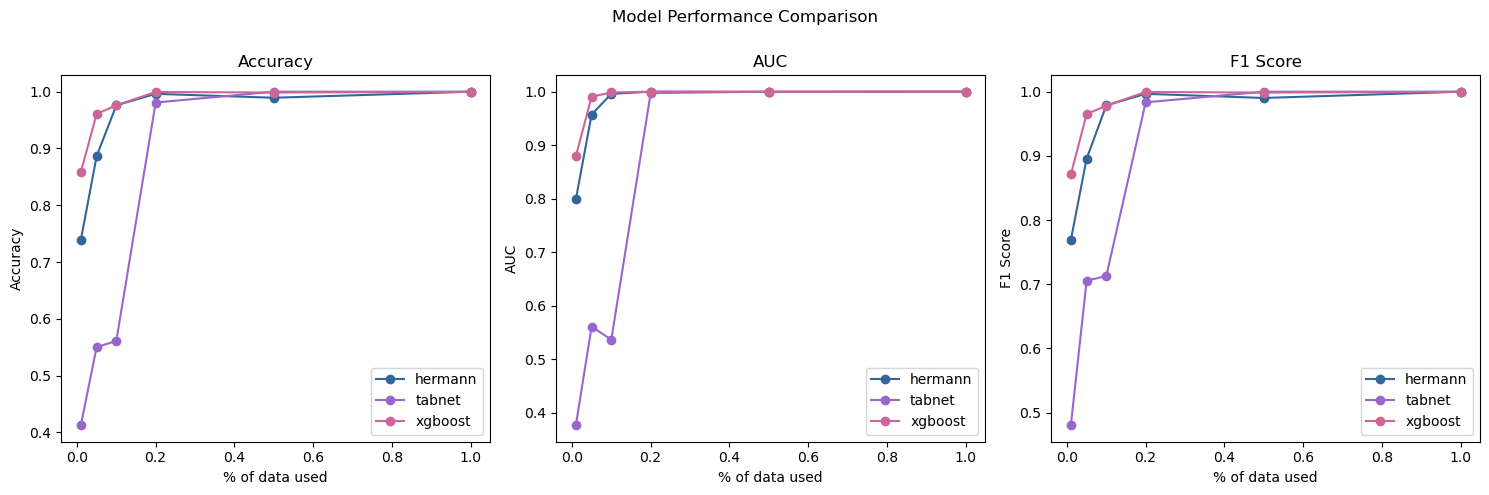

In [13]:
import matplotlib.pyplot as plt

# List of thresholds
thresholds = [1, 0.5, 0.2, 0.1, 0.05, 0.01]

results = []
for t in thresholds:
  results.append(run_all(1-t))

# List of metrics
metrics = ['Accuracy', 'AUC', 'F1 Score']

# Prepare the plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Model Performance Comparison')

# Plot the results
for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(thresholds, [r['hermann'][i] for r in results], label='hermann', marker='o',c=(0.2, 0.4, 0.6))
    ax.plot(thresholds, [r['tabnet'][i] for r in results], label='tabnet', marker='o',c=(0.6, 0.4, 0.8))
    ax.plot(thresholds, [r['xgboost'][i] for r in results], label='xgboost', marker='o',c=(0.8, 0.4, 0.6))
    ax.set_title(metric)
    ax.set_xlabel('% of data used')
    ax.set_ylabel(metric)
    ax.legend()

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig("result.png")
plt.show()